In [57]:
import os

import numpy as np
import pandas as pd

from dotenv import load_dotenv

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
load_dotenv()
base_dir = os.getenv("SCRATCH_DIR")
output_dir = os.path.join(base_dir, "output")
behav_dir = os.path.join(output_dir, "behav_results")

In [15]:
affair_file = os.path.join(behav_dir, "individual_response_evidence_affair.pkl")
paranoia_file = os.path.join(behav_dir, "individual_response_evidence_paranoia.pkl")
segment_file = os.path.join(behav_dir, "prominent_peaks_filtered_023.txt")

In [16]:
affair_evidence = pd.read_pickle(affair_file)
paranoia_evidence = pd.read_pickle(paranoia_file)
segment = np.loadtxt(segment_file, dtype=int)

In [19]:
segment

array([ 62, 117, 165, 205, 245, 274, 293, 306, 317, 342, 359, 376, 440,
       452])

In [20]:
affair_ts = np.mean(np.array(affair_evidence["binary_response"].tolist()), axis=0)
paranoia_ts = np.mean(np.array(paranoia_evidence["binary_response"].tolist()), axis=0)

In [21]:
affair_ts.shape

(465,)

In [31]:
def get_seg_evidence(boundaries: np.ndarray, evidence_ts: np.ndarray) -> np.ndarray:
    
    seg_evidence = []

    max_len = 0
    for i, r in enumerate(boundaries):

        end = r 

        if i == 0:
            start = 14 
        else:
            start = boundaries[i - 1] 
            
        # Ensure start and end are within bounds
        start = max(0, min(start, evidence_ts.shape[0]))
        end = max(0, min(end, evidence_ts.shape[0]))
        
        segment = evidence_ts[start:end]
        seg_evidence.append(segment)
        max_len = max(max_len, segment.shape[0])
        print(f"Processed segment {i}: start {start}, end {end}, segment length {segment.shape[0]}")
    
    seg_evidence.append(evidence_ts[end:465])
    print(f"Number of segments: {len(seg_evidence)}")
    
    # Pad each segment to the maximum length with NaN
    padded_segments = []
    for segment in seg_evidence:
        pad_width = ((0, max_len - segment.shape[0]))
        padded_segment = np.pad(segment, pad_width, mode='constant', constant_values=np.nan)
        padded_segments.append(padded_segment)

    # Create output matrix
    output_mtx = np.stack(padded_segments, axis=0)
    # Transpose to make n_seg the last dimension
    print(f"before output_mtx shape: {output_mtx.shape}")
    # output_mtx = np.transpose(output_mtx, [1, 2, 3, 4, 0])
    # print(f"output mtx shape: {output_mtx.shape}")
    return output_mtx

In [32]:
seg_affair = get_seg_evidence(segment, affair_ts)
seg_paranoia = get_seg_evidence(segment, paranoia_ts)

Processed segment 0: start 14, end 62, segment length 48
Processed segment 1: start 62, end 117, segment length 55
Processed segment 2: start 117, end 165, segment length 48
Processed segment 3: start 165, end 205, segment length 40
Processed segment 4: start 205, end 245, segment length 40
Processed segment 5: start 245, end 274, segment length 29
Processed segment 6: start 274, end 293, segment length 19
Processed segment 7: start 293, end 306, segment length 13
Processed segment 8: start 306, end 317, segment length 11
Processed segment 9: start 317, end 342, segment length 25
Processed segment 10: start 342, end 359, segment length 17
Processed segment 11: start 359, end 376, segment length 17
Processed segment 12: start 376, end 440, segment length 64
Processed segment 13: start 440, end 452, segment length 12
Number of segments: 15
before output_mtx shape: (15, 64)
Processed segment 0: start 14, end 62, segment length 48
Processed segment 1: start 62, end 117, segment length 55
P

In [34]:
def mannwhitneyu_nan_aware(a, b):
    # Remove NaN values
    a = a[~np.isnan(a)]
    b = b[~np.isnan(b)]
    # Perform the Mann-Whitney U test
    _, p_value = mannwhitneyu(a, b)
    return p_value


In [35]:
p_values = []
for seg1, seg2 in zip(seg_affair, seg_paranoia):
    p_value = mannwhitneyu_nan_aware(seg1, seg2)
    p_values.append(p_value)


In [38]:
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]
results = pd.DataFrame({'Segment': range(1, len(p_values) + 1), 'p-value': p_values, 'Adjusted p-value': adjusted_p_values})

In [39]:
results

,Segment,p-value,Adjusted p-value
0,1,0.004193,0.015283
1,2,0.207550,0.283022
2,3,0.171749,0.262923
3,4,0.161722,0.262923
4,5,0.828526,0.828526
5,6,0.573027,0.613957
6,7,0.003529,0.015283
7,8,0.567564,0.613957
8,9,0.003985,0.015283
9,10,0.019170,0.047924


In [58]:
# Standardization
scaler = StandardScaler()
ts1_scaled = scaler.fit_transform(seg_affair.reshape(-1, 1)).flatten()
ts2_scaled = scaler.fit_transform(seg_paranoia.reshape(-1, 1)).flatten()

# Reshape back to original 2D form
time_series1_scaled = ts1_scaled.reshape(seg_affair.shape)
time_series2_scaled = ts2_scaled.reshape(seg_paranoia.shape)

In [61]:
time_series1_scaled.shape

(15, 64)

In [66]:
def euclidean_distance_nan_aware(a, b):
    # Remove NaN values
    valid_indices = ~np.isnan(a) & ~np.isnan(b)
    a = a[valid_indices]
    b = b[valid_indices]
    return euclidean(a, b)

distances = [euclidean_distance_nan_aware(seg1, seg2) for seg1, seg2 in zip(time_series1_scaled, time_series2_scaled)]


In [67]:
distances

[5.5173047439505645,
 11.117482566206963,
 12.043051475562507,
 9.548273628883882,
 7.173485519186369,
 9.993319388367896,
 6.644776201723407,
 3.583219745602793,
 7.001151286268264,
 4.881451629658581,
 3.0245331036526535,
 5.5233791388244775,
 5.803776195503177,
 2.7843214632036775,
 0.9429887299918256]

In [68]:
def permutation_test(time_series1, time_series2, n_permutations=10000):
    n_segments, segment_length = time_series1.shape
    combined = np.concatenate((time_series1, time_series2), axis=0)
    permuted_distances = np.zeros((n_permutations, n_segments))

    for i in range(n_permutations):
        np.random.shuffle(combined)
        permuted_series1 = combined[:n_segments]
        permuted_series2 = combined[n_segments:]
        
        for j in range(n_segments):
            permuted_distances[i, j] = euclidean_distance_nan_aware(permuted_series1[j], permuted_series2[j])
    
    return permuted_distances

n_permutations = 10000
permuted_distances = permutation_test(time_series1_scaled, time_series2_scaled, n_permutations=n_permutations)


In [69]:
p_values = []
for i in range(len(distances)):
    p_value = np.mean(permuted_distances[:, i] >= distances[i])
    p_values.append(p_value)

# Adjust for multiple comparisons
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

results = pd.DataFrame({'Segment': range(1, len(p_values) + 1), 'Distance': distances, 'p-value': p_values, 'Adjusted p-value': adjusted_p_values})


In [70]:
results

,Segment,Distance,p-value,Adjusted p-value
0,1,5.517305,0.4466,0.669900
1,2,11.117483,0.0582,0.372750
2,3,12.043051,0.0307,0.372750
3,4,9.548274,0.0994,0.372750
4,5,7.173486,0.2620,0.669900
5,6,9.993319,0.0838,0.372750
6,7,6.644776,0.3467,0.669900
7,8,3.583220,0.6069,0.732107
8,9,7.001151,0.2736,0.669900
9,10,4.881452,0.4996,0.681273


In [79]:
segment

array([ 62, 117, 165, 205, 245, 274, 293, 306, 317, 342, 359, 376, 440,
       452])

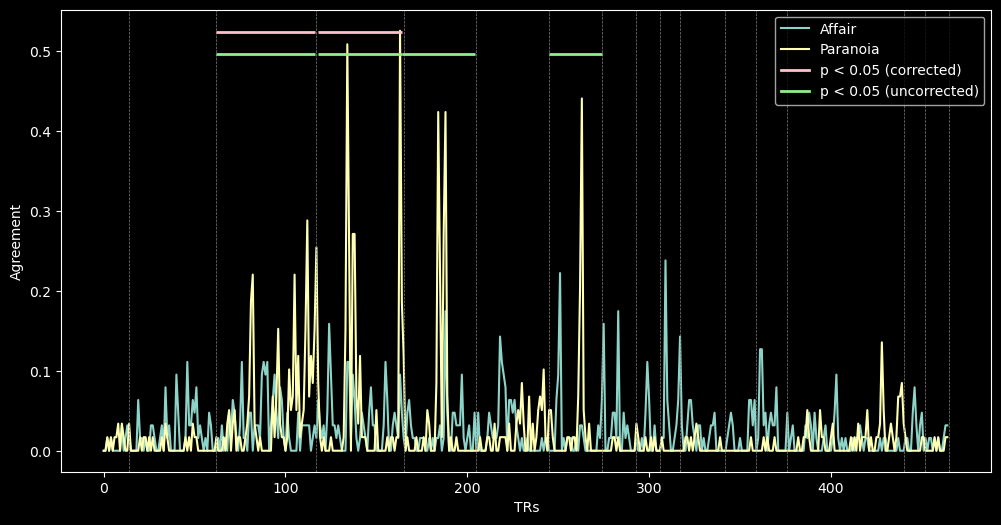

In [96]:
# Create a figure and a plot
plt.figure(figsize=(12, 6))
plt.plot(affair_ts, label='Affair')
plt.plot(paranoia_ts, label='Paranoia')

# Add vertical lines for segments using segment boundaries
for boundary in segment:
    plt.axvline(x=boundary, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=14, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=465, color='gray', linestyle='--', linewidth=0.5)


horizontal_lines_1 = [(62, 116), (118, 164)]  # Example coordinates for horizontal lines
horizontal_label_1 = 'p < 0.05 (corrected)'
horizontal_color_1 = 'pink'

horizontal_lines_2 = [(62, 116), (118, 164), (164, 204), (245, 274)]  # Example coordinates for horizontal lines
horizontal_label_2 = 'p < 0.05 (uncorrected)'
horizontal_color_2 = 'lightgreen'


for start, end in horizontal_lines_1:
    y_position_1 = plt.ylim()[1] * 0.95
    plt.hlines(y=y_position_1, xmin=start, xmax=end, color=horizontal_color_1, linewidth=2)

for start, end in horizontal_lines_2:
    y_position_2 = plt.ylim()[1] * 0.9
    plt.hlines(y=y_position_2, xmin=start, xmax=end, color=horizontal_color_2, linewidth=2)

# Add a common label for the horizontal lines
# Place the label at the first line's start for clarity
# plt.text(horizontal_lines[0][0], y_position, horizontal_label, verticalalignment='bottom', horizontalalignment='left', color=horizontal_color, fontsize=10)
# Add a dummy line for the legend
plt.plot([], [], color=horizontal_color_1, label=horizontal_label_1, linewidth=2)
plt.plot([], [], color=horizontal_color_2, label=horizontal_label_2, linewidth=2)

# Enhance the plot
# plt.title('Comparison of Two Time Series with Segment Boundaries')
plt.xlabel('TRs')
plt.ylabel('Agreement')
plt.legend(loc='upper right')
# plt.grid(True)

# Show the plot
plt.show()

In [76]:
def permutation_test(time_series1, time_series2, n_permutations=1000):
    combined1 = np.hstack(time_series1)
    combined2 = np.hstack(time_series2)
    combined = np.concatenate((combined1, combined2))
    segment_lengths = [len(segment[~np.isnan(segment)]) for segment in time_series1]
    n_segments = len(segment_lengths)
    
    permuted_distances = np.zeros((n_permutations, n_segments))

    for i in range(n_permutations):
        np.random.shuffle(combined)
        permuted_series1 = combined[:len(combined1)].reshape(time_series1.shape)
        permuted_series2 = combined[len(combined1):].reshape(time_series2.shape)
        
        for j in range(n_segments):
            permuted_distances[i, j] = euclidean_distance_nan_aware(permuted_series1[j], permuted_series2[j])
    
    return permuted_distances

n_permutations = 10000
permuted_distances = permutation_test(time_series1_scaled, time_series2_scaled, n_permutations=n_permutations)


In [77]:
p_values = []
for i in range(len(distances)):
    p_value = np.mean(permuted_distances[:, i] >= distances[i])
    p_values.append(p_value)

# Adjust for multiple comparisons
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

results = pd.DataFrame({'Segment': range(1, len(p_values) + 1), 'Distance': distances, 'p-value': p_values, 'Adjusted p-value': adjusted_p_values})


In [78]:
results

,Segment,Distance,p-value,Adjusted p-value
0,1,5.517305,0.3366,0.504900
1,2,11.117483,0.0033,0.024750
2,3,12.043051,0.0017,0.024750
3,4,9.548274,0.0290,0.108750
4,5,7.173486,0.1623,0.440500
5,6,9.993319,0.0187,0.093500
6,7,6.644776,0.2138,0.458143
7,8,3.583220,0.6775,0.846875
8,9,7.001151,0.1762,0.440500
9,10,4.881452,0.4362,0.594818
